In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

2023-10-29 16:57:49.791063: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 16:57:50.664781: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Data

The original dataset has taxa counts as rows and samples as columns. Since the goal here is to predict taxa counts in the same sample I transpose the original data such that one row represents taxa counts from the same sample. 

In [2]:
df = pd.read_csv(df_path, index_col="Unnamed: 0").T

In [3]:
print(df)

              1050608  130468   3589405  355102   1081058  189592   354275   \
E000823.1.8         0        0        0        0        0        0        0   
E000823.2.6         0        0        0        0        0        0        0   
E000823.4.0         0        0        0        0        0        0        0   
E000823.5.0         0        0        0        0        0        0        0   
E000823.5.7         0        0        0        0        0        0        0   
...               ...      ...      ...      ...      ...      ...      ...   
E014086.30.4        0        0        0        0        0        1       11   
E014086.32.4        0        0        0        0        0        0       13   
E014086.33.5        0        0        0        0        0        0        0   
E014086.34.4        0        0        0        0        0        1        0   
E014086.36.0        0        0        0        0        0        0        0   

              4327628  326749   183857   ...  31792

The dataset contains 521 samples of 7244 taxa, most of which are very sparsely populated 

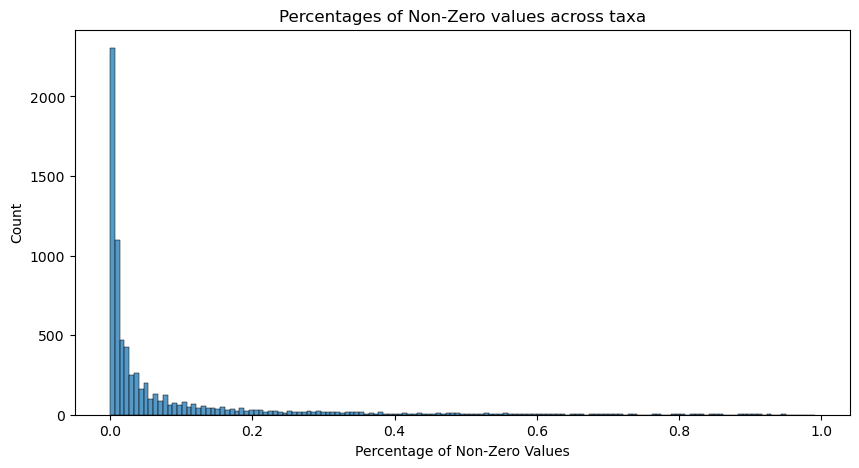

In [4]:
non_zero_value_counts = pd.Series([len(df[col][df[col] != 0]) for col in df.columns])
non_zero_value_pcts = non_zero_value_counts / len(df)

plt.figure(figsize=(10,5))
sns.histplot(non_zero_value_pcts)
plt.title("Percentages of Non-Zero values across taxa")
plt.xlabel("Percentage of Non-Zero Values")
plt.show()

In [5]:
non_zero_value_counts.describe()

count   7244.000000
mean      38.409856
std       71.884313
min        0.000000
25%        3.000000
50%        9.000000
75%       37.000000
max      516.000000
dtype: float64

### Preprocessing

In [6]:
df = load_and_merge()

In [7]:
max_zeros_pct = 0.5
window_size = 3
sequence_length = 10

df = load_and_merge()

df = remove_underpopulated_taxa(df, max_zeros_pct)
df = standard_rolling_average(df, window_size)
df = feature_wise_scaling(df)

In [8]:
df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,3304236,584137,193233,4334711,196664,583117,354850,subject_id,sampling_day,ind_time
E000823.4.0,0.000000,0.000160,0.288889,0.000000,0.000000,0.242718,0.010256,0.190476,0.000000,0.100671,...,0.029412,0.000000,0.040201,0.455696,0.059699,0.010154,0.064039,E000823,0.072046,0.072046
E000823.5.0,0.000000,0.000160,0.200000,0.000000,0.000000,0.199029,0.007692,0.119048,0.000000,0.120805,...,0.117647,0.000000,0.035804,0.398734,0.054162,0.010779,0.029557,E000823,0.100865,0.100865
E000823.5.7,0.000000,0.000180,0.200000,0.003724,0.000000,0.228155,0.007692,0.023810,0.000000,0.053691,...,0.117647,0.000000,0.034338,0.518987,0.060045,0.009685,0.019704,E000823,0.121037,0.121037
E000823.6.7,0.065636,0.000160,0.088889,0.016139,0.000000,0.121359,0.002564,0.023810,0.000000,0.080537,...,0.205882,0.000085,0.021566,0.386076,0.035127,0.006092,0.000000,E000823,0.149856,0.149856
E000823.8.5,0.065636,0.000220,0.177778,0.017381,0.000000,0.490291,0.020513,0.071429,0.000000,0.053691,...,0.176471,0.000085,0.050251,0.386076,0.061602,0.037334,0.000000,E000823,0.201729,0.201729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.30.4,0.060355,0.080890,0.288889,0.007449,0.044379,0.111650,0.025641,0.476190,0.479017,0.503356,...,0.470588,0.055292,0.091290,0.253165,0.127531,0.423113,0.068966,E014086,0.832853,0.832853
E014086.32.4,0.060355,0.120524,0.622222,0.010552,0.077663,0.194175,0.071795,0.404762,0.880928,0.711409,...,0.441176,0.071990,0.142169,0.341772,0.345042,0.622876,0.285714,E014086,0.890490,0.890490
E014086.33.5,0.051679,0.141802,1.000000,0.011173,0.161243,0.436893,0.074359,0.619048,0.849198,0.906040,...,0.264706,0.057024,0.213358,0.373418,0.537809,0.756436,0.507389,E014086,0.922190,0.922190
E014086.34.4,0.021124,0.127490,0.977778,0.004345,0.160503,0.572816,0.071795,0.571429,0.761174,0.899329,...,0.294118,0.037543,0.241625,0.316456,0.631597,0.749125,0.610837,E014086,0.948127,0.948127


### Features and tergets


In [9]:
number_test_sequences = 3

train_feats, train_targets, test_feats, test_targets, test_subjects = feats_and_targets(df, seq_length=sequence_length, n_test_seq=number_test_sequences)

The test subjects are ['E006493' 'E001958' 'E010481']


In [10]:
print(len(train_feats), len(train_targets))


265 265


### The Model

In [11]:
reg = 1e-12
loss=mae_ignore_zeros(false_positives_penalty_factor=0.3)

n_feats = len(df.columns) - 1

model = Sequential()
model.add(keras.Input(shape=(sequence_length, n_feats)))
model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
model.add(keras.layers.Dense(2048, activation="tanh", kernel_regularizer=l1_l2(reg)))
model.add(keras.layers.Dense(n_feats, activation="relu", kernel_regularizer=l1_l2(reg)))

model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])

model.summary()

2023-10-29 16:57:55.068111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-29 16:57:55.093813: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-29 16:57:55.094271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1024)              5033984   
                                                                 
 dense (Dense)               (None, 2048)              2099200   
                                                                 
 dense_1 (Dense)             (None, 204)               417996    
                                                                 
Total params: 7551180 (28.81 MB)
Trainable params: 7551180 (28.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training and Validation

In [12]:
train_feats = np.asarray(train_feats)

model.fit(x=train_feats, y=train_targets, validation_split=0.05, epochs=100)

Epoch 1/100


2023-10-29 16:57:57.998753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-29 16:57:58.040735: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f064c026e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-29 16:57:58.040774: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-10-29 16:57:58.046923: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-29 16:57:58.061481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-29 16:57:58.174965: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

8/8 [==============================] - 3s 49ms/step - loss: 27.0163 - mae: 0.0984 - mape: 1537242.0000 - val_loss: 22.8664 - val_mae: 0.0819 - val_mape: 644571.3125
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 21.4053 - mae: 0.0802 - mape: 572158.2500 - val_loss: 19.1095 - val_mae: 0.0752 - val_mape: 685343.1250
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 17.8083 - mae: 0.0728 - mape: 485399.2188 - val_loss: 16.2772 - val_mae: 0.0711 - val_mape: 631163.6875
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 15.2149 - mae: 0.0685 - mape: 356930.6875 - val_loss: 14.0361 - val_mae: 0.0665 - val_mape: 629934.0000
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 13.3779 - mae: 0.0657 - mape: 350909.1875 - val_loss: 12.5824 - val_mae: 0.0651 - val_mape: 514297.5938
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 12.0168 - mae: 0.0636 - mape: 258434.5156 - val_loss: 11.65

In [13]:
test_subjects

array(['E006493', 'E001958', 'E010481'], dtype=object)

In [19]:
target_subject_idx = 0
target_subject = test_subjects[target_subject_idx]

test_subject_feats = np.asarray(test_feats[target_subject])

test_subject_targets_df = pd.concat(test_targets[target_subject], axis=1).T
test_subject_targets_df.columns = df.columns[:-1]

In [20]:
test_subject_y_pred = model.predict(test_subject_feats)
test_subject_y_pred_df = pd.DataFrame(test_subject_y_pred)
test_subject_y_pred_df.columns = test_subject_targets_df.columns
test_subject_y_pred_df.index = test_subject_targets_df.index

test_subject_y_pred_df

1/1 [==============================] - 0s 24ms/step


,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,922761,3304236,584137,193233,4334711,196664,583117,354850,subject_id,sampling_day
E006493.13.6,0.000000,0.000000,0.367492,0.000000,0.043176,0.133270,0.103029,0.000000,0.019685,0.226843,...,0.000000,0.304691,0.000000,0.184255,0.186441,0.162988,0.309153,0.367812,0.387993,0.381851
E006493.14.4,0.002942,0.000000,0.322163,0.001166,0.035786,0.119816,0.088395,0.000000,0.020600,0.195001,...,0.000000,0.233116,0.000000,0.160555,0.152843,0.138415,0.272775,0.303532,0.386490,0.382539
E006493.15.4,0.001481,0.000000,0.322467,0.002840,0.039379,0.156051,0.083295,0.000000,0.006738,0.135846,...,0.000000,0.193519,0.000000,0.155110,0.179364,0.129071,0.255581,0.307051,0.386373,0.384044
E006493.16.8,0.000000,0.000000,0.264637,0.000000,0.102159,0.150152,0.140523,0.000000,0.025849,0.222367,...,0.000000,0.189302,0.000000,0.249216,0.149777,0.154049,0.222283,0.303291,0.508666,0.504728
E006493.20.5,0.000000,0.000000,0.202348,0.000000,0.109243,0.151866,0.136041,0.000000,0.035827,0.299978,...,0.000000,0.183788,0.000000,0.275692,0.111880,0.173764,0.195349,0.275343,0.582677,0.576332
E006493.22.8,0.000000,0.000000,0.153631,0.000000,0.077560,0.149025,0.067330,0.000000,0.082688,0.341777,...,0.000000,0.181403,0.000000,0.192490,0.099127,0.153610,0.144505,0.318500,0.680667,0.673901
E006493.23.7,0.000000,0.000000,0.055893,0.000000,0.011128,0.063206,0.000000,0.000000,0.115696,0.235252,...,0.000000,0.111275,0.000000,0.057270,0.058982,0.067565,0.061134,0.242458,0.668594,0.661139
E006493.24.1,0.011819,0.000000,0.061271,0.000000,0.001679,0.049630,0.000000,0.000000,0.108503,0.196980,...,0.000000,0.112379,0.000000,0.046651,0.054938,0.056305,0.066373,0.211776,0.646743,0.639690
E006493.24.6,0.007000,0.000000,0.093948,0.000000,0.002452,0.064637,0.046591,0.000000,0.083457,0.187021,...,0.000000,0.122614,0.000000,0.089322,0.060430,0.081337,0.103892,0.203531,0.614168,0.608321
E006493.27.4,0.001853,0.000000,0.132486,0.000000,0.007434,0.083113,0.090895,0.000000,0.084574,0.200589,...,0.000000,0.153397,0.000000,0.131067,0.066691,0.109458,0.139607,0.203523,0.619362,0.614754


Usually at least some of the taxa are not predictable by a model. Then it returns zeros for their entire sequence

In [21]:
non_predicted_cols = [col for col in test_subject_y_pred_df.columns if all(test_subject_y_pred_df[col] == 0.0)]
n_non_predicted_cols = len(non_predicted_cols)

print(f"Total taxa not predicted: {n_non_predicted_cols}, {(n_non_predicted_cols/len(test_subject_targets_df.columns)) * 100}% of all taxa")

Total taxa not predicted: 30, 14.705882352941178% of all taxa


The next section allows to examine individual true and predicted sequences

In [22]:
test_subjects = test_subject_targets_df.subject_id.unique()
test_subjects

array([0.34870317, 0.37175793, 0.40057637, 0.44092219, 0.54755043,
       0.61383285, 0.63976945, 0.65129683, 0.66570605, 0.74639769,
       0.76368876, 0.81556196, 0.85302594, 0.87608069, 0.94236311,
       0.95100865, 0.98847262])

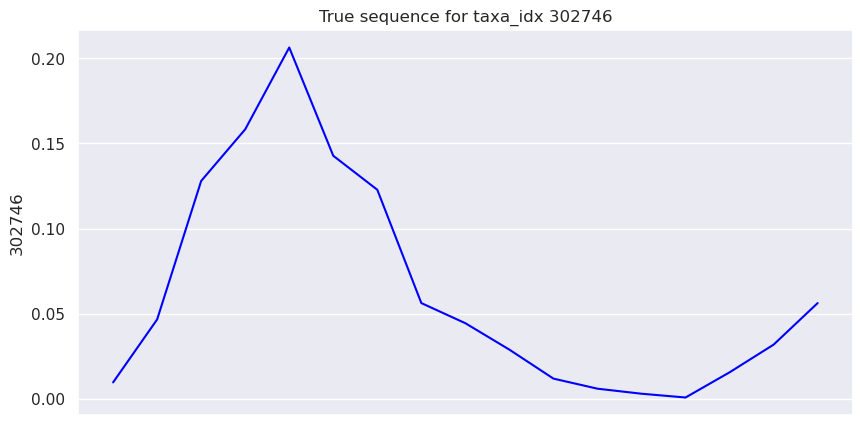

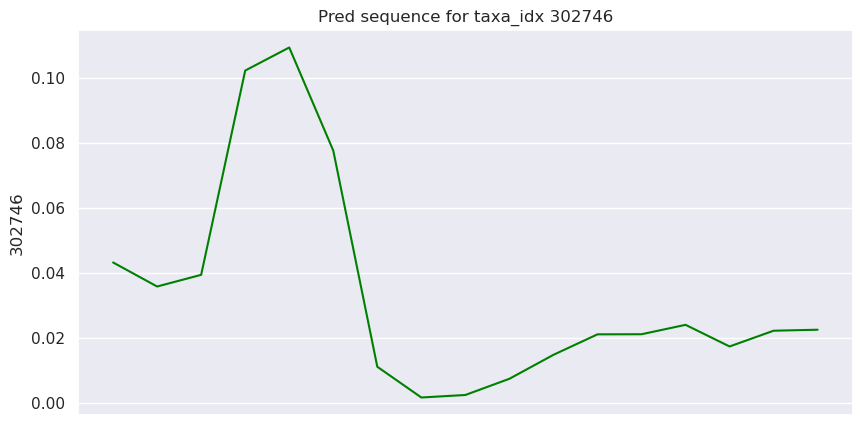

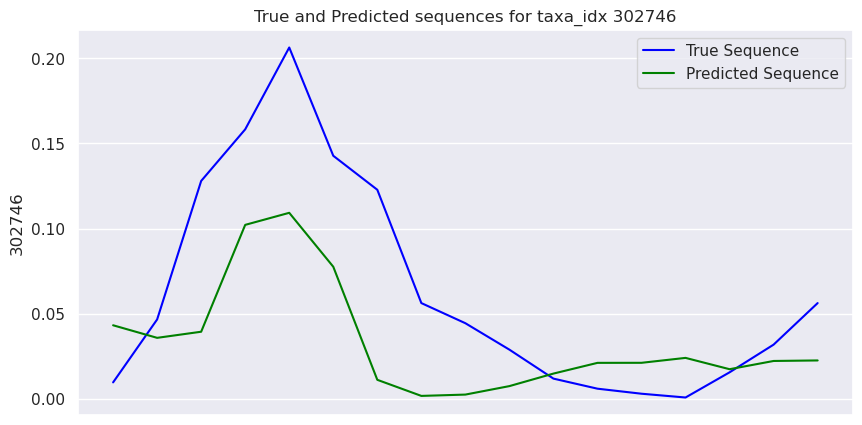

In [24]:
target_taxa = 302746
target_subject_idx = 0

target_subject = test_subjects[target_subject_idx]

true_sequence = test_subject_targets_df[target_taxa].reset_index(drop=True)
pred_sequence = test_subject_y_pred_df[target_taxa].reset_index(drop=True)

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

Now I look at the performance across different sequences

In [25]:
errors_df = calculate_percentage_errors(test_subject_y_pred_df, test_subject_targets_df)
errors_df.describe()


,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,...,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,1.586401,0.999999,0.374756,686008.506688,2.982237,0.644625,0.563427,1.000000,2.011323,0.400569,...,1.247168,0.900450,0.823529,0.331778,0.823529,0.422054,1.795970,0.331599,0.235819,178548064.623908
std,2.143552,0.000001,0.252250,2828482.550170,7.499938,0.677251,0.595275,0.000000,2.705499,0.213506,...,1.720977,0.927372,0.392953,0.180267,0.392952,0.593709,2.376071,0.225654,0.186882,736172520.603865
min,0.214905,0.999995,0.007714,0.000000,0.117807,0.117303,0.034705,1.000000,0.143654,0.149528,...,0.046291,0.016167,0.000000,0.007567,0.000000,0.024420,0.015478,0.070556,0.014330,0.010242
25%,0.912456,1.000000,0.227611,0.000000,0.354587,0.181862,0.175989,1.000000,0.730929,0.272503,...,0.219234,0.312035,1.000000,0.233539,0.999998,0.150081,0.479043,0.127864,0.067578,0.205448
50%,0.977300,1.000000,0.306397,1.000000,0.692251,0.395412,0.376544,1.000000,0.837324,0.350186,...,0.531899,0.584149,1.000000,0.305188,0.999999,0.225982,1.170048,0.258663,0.253453,0.516961
75%,1.000000,1.000000,0.540465,1.000000,0.970137,0.675236,0.626609,1.000000,1.065716,0.497790,...,1.440739,1.321521,1.000000,0.423025,1.000000,0.455389,2.132416,0.468330,0.331250,4.225210
max,9.078410,1.000000,0.987284,11662133.038044,31.462839,2.436805,2.463862,1.000000,8.688673,1.037717,...,6.021805,3.636418,1.000000,0.607099,1.000000,2.534513,9.537210,0.879324,0.739297,3035317063.331604


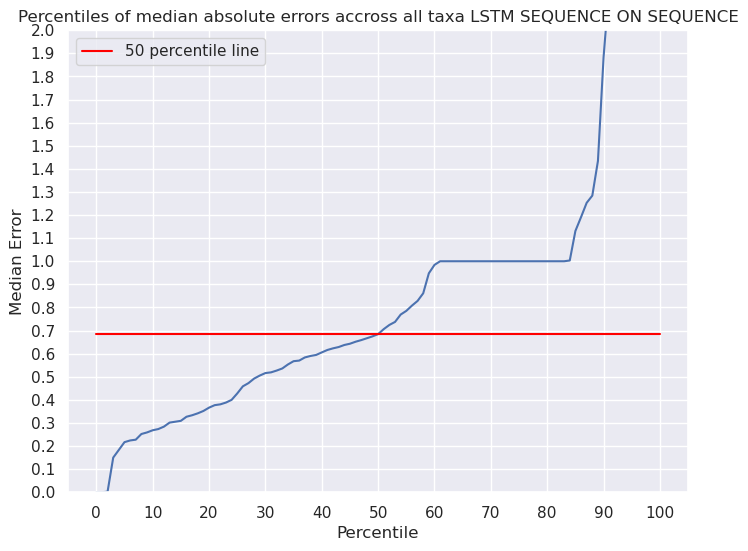

In [26]:
percentile_graph(errors_df, "accross all taxa LSTM SEQUENCE ON SEQUENCE", y_top_lim=2)

Same graph, but only for those taxa that are not all predicted zero

In [27]:
only_predicted_errors = errors_df[errors_df.columns[~(errors_df.columns.isin(non_predicted_cols))]]
only_predicted_errors.describe()

,659361,3439402,181155,302746,4473763,175535,585227,189384,3465320,865469,...,2283111,577170,359650,130663,3304236,193233,4334711,196664,583117,354850
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,...,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,1.586401,0.374756,686008.506688,2.982237,0.644625,0.563427,2.011323,0.400569,1.224771,37.548454,...,1.313111,0.451577,1.247168,0.900450,0.331778,0.422054,1.795970,0.331599,0.235819,178548064.623908
std,2.143552,0.252250,2828482.550170,7.499938,0.677251,0.595275,2.705499,0.213506,1.039248,75.859539,...,1.071292,0.229803,1.720977,0.927372,0.180267,0.593709,2.376071,0.225654,0.186882,736172520.603865
min,0.214905,0.007714,0.000000,0.117807,0.117303,0.034705,0.143654,0.149528,0.145579,0.127505,...,0.007101,0.139040,0.046291,0.016167,0.007567,0.024420,0.015478,0.070556,0.014330,0.010242
25%,0.912456,0.227611,0.000000,0.354587,0.181862,0.175989,0.730929,0.272503,0.344311,0.702084,...,0.533818,0.259116,0.219234,0.312035,0.233539,0.150081,0.479043,0.127864,0.067578,0.205448
50%,0.977300,0.306397,1.000000,0.692251,0.395412,0.376544,0.837324,0.350186,0.844751,3.915116,...,1.000000,0.429575,0.531899,0.584149,0.305188,0.225982,1.170048,0.258663,0.253453,0.516961
75%,1.000000,0.540465,1.000000,0.970137,0.675236,0.626609,1.065716,0.497790,1.799692,30.108336,...,2.052710,0.630816,1.440739,1.321521,0.423025,0.455389,2.132416,0.468330,0.331250,4.225210
max,9.078410,0.987284,11662133.038044,31.462839,2.436805,2.463862,8.688673,1.037717,3.623650,249.258596,...,3.545427,0.964308,6.021805,3.636418,0.607099,2.534513,9.537210,0.879324,0.739297,3035317063.331604


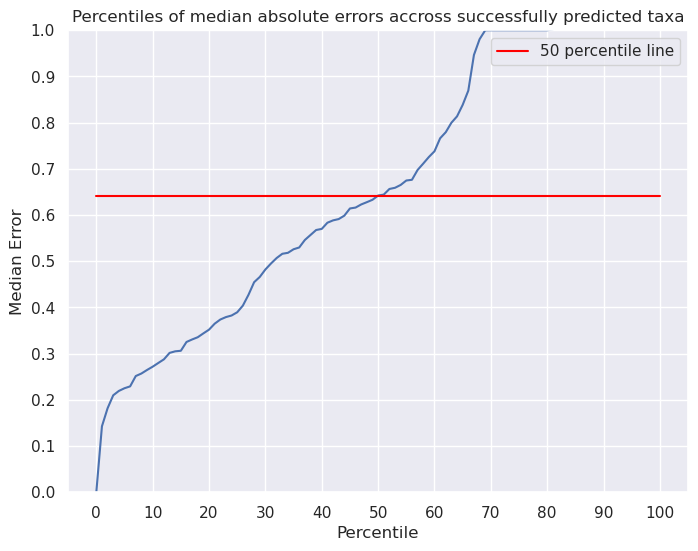

In [28]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa", y_top_lim=1)

In [29]:
def feats_and_targets(df, seq_length):

    feats = []
    targets = []
    
    subjects = df.subject_id.unique()
    df_subject_grp = df.groupby("subject_id")
    
    for subject_id in subjects:
        subject_df = df_subject_grp.get_group(subject_id).drop(columns=["subject_id"])
        subject_feats, subject_targets = cut_to_sequences(subject_df, seq_length=seq_length)
    
        for sequence_idx in range(len(subject_feats)):
            feats.append(subject_feats[sequence_idx])
            targets.append(subject_targets[sequence_idx])
    
    targets = pd.concat(targets, axis=1).T
    feats = np.asarray(feats)
    
    return feats, targets